## Investigating model behavior in detail
This is a notebook showing one specific example of how we can delve into technical questions of model behavior.  

We are going to investigate how the timestep interval affects the behavior of the within-host model dynamics, noting that larger timesteps result in faster evaluation, but less precise integration of antigen/antibody interactions.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from emodlib.malaria import IntrahostComponent

Below is a similar function as we've defined elsewhere to evaluate the dynamics of a single infection in an immuno-naive individual.

However, in this instance, we'll also introduce a time-step size (dt) that we'll vary across different simulation runs.

In [3]:
def run_challenge(duration, dt=1):

    ts = np.arange(0, duration, dt)
    n_ts = len(ts)
    asexuals = np.zeros(n_ts)
    gametocytes = np.zeros(n_ts)
    fevers = np.zeros(n_ts)

    ic = IntrahostComponent.create()
    ic.challenge()

    for i, t in enumerate(ts):
        # print('t = %f', t)
        ic.update(dt=dt)
        asexuals[i] = ic.parasite_density
        gametocytes[i] = ic.gametocyte_density
        fevers[i] = ic.fever_temperature

    return pd.DataFrame({'days': ts + dt,
                         'parasite_density': asexuals,
                         'gametocyte_density': gametocytes,
                         'fever_temperature': fevers}).set_index('days')


def plot_timeseries(df):
    fig, ax = plt.subplots(1, 1, figsize=(8, 3))
    df[['parasite_density', 'gametocyte_density']].plot(ax=ax, color=dict(parasite_density='navy', gametocyte_density='darkgreen'))
    ax.set(yscale='log')
    fig.set_tight_layout(True)

### Comparing duration of time step on within-host dynamics
Here's a scenario where we do 2 time-step updates per day (dt=0.5)

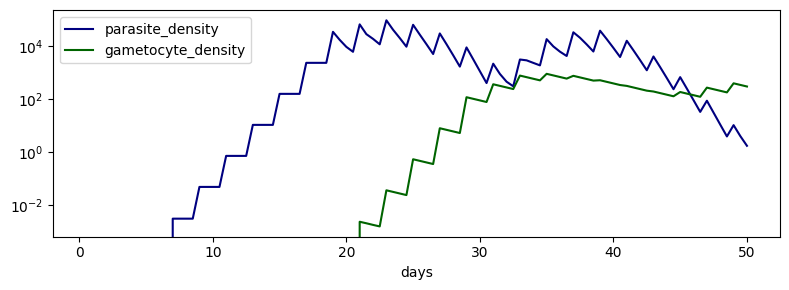

In [4]:
df_ts2 = run_challenge(duration=50, dt=0.5)
plot_timeseries(df_ts2)

What's going on in this time series?  

The dominant features of the parasite-density series (in blue) are:
 - 48h cycle of infected red-blood cell (IRBC) rupture and multiplication of parasite density (steps up)
 - Antibody killing starting to kick in (around day 19) + evaluated on every time step (downward slope between 48h cycles)

The gametocyte-density series (in green) is characterized by a lag relative to the parasite-density series.  Note also that mature gametocytes decay in the blood at the same rate in all time periods (see [corresponding code](https://github.com/edwenger/emodlib/blob/e115f3b26db89b8624e767c66f3b597b9f9c4c48/include/emodlib/malaria/InfectionMalaria.cpp#L495) in Infection class).

For contrast, now let's run a scenario where we do 8 time-step updates per day (dt=0.125)

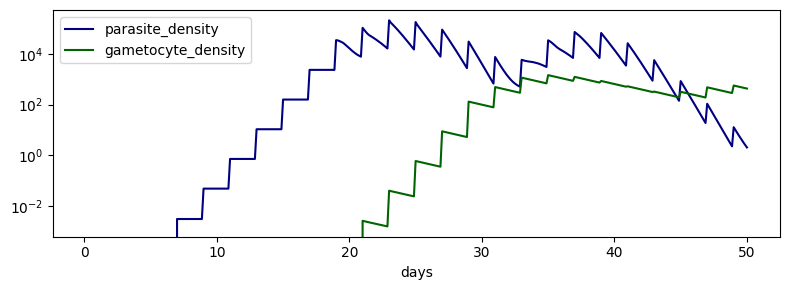

In [5]:
df_ts8 = run_challenge(duration=50, dt=0.125)
plot_timeseries(df_ts8)

And a couple subtle behaviors that are more apparent with 8 time steps per day:
- In the first cycle with antibody-killing (days 18 to 20), there's actually a steeper slope towards the end of that period, reflecting the transition across a sigmoidal killing rate as a function of the growing antibody concentration.
- In the following cycle (days 20 to 22), the steeper decay in first small timestep relates to higher cytokine-killing effects in response to merozoite release from ruptured schizonts -- on top of the PfEMP1 antibody killing applied at all small timesteps.

### Isolating antibody-killing effects

Ok.  Now let's try isolating just the continuously evaluated PfEMP1-related antibody-killing behavior in this example.

To do that, we are going to toggle off both of the following:
- fever-killing (induced through cytokine production)
- merozoite-killing (assessed with IRBC rupture every 48h cycle) 

In [6]:
IntrahostComponent.update_params({
    'susceptibility_params': {
        'Fever_IRBC_Kill_Rate': 0}, 
    'infection_params': {
        'MSP1_Merozoite_Kill_Fraction': 0}})

After re-running our two time-step-size scenarios with the updated parameters changed above, we can plot direct comparisons by channel...

In [7]:
df_ts2 = run_challenge(duration=50, dt=0.5)
df_ts8 = run_challenge(duration=50, dt=0.125)

def compare_timeseries(df1, df2, channel='parasite_density'):
    fig, ax = plt.subplots(1, 1, figsize=(8, 3))
    df1[channel].plot(ax=ax, color='r')
    df2[channel].plot(ax=ax, color='navy')
    ax.set(yscale='log', ylabel=channel)
    fig.set_tight_layout(True)

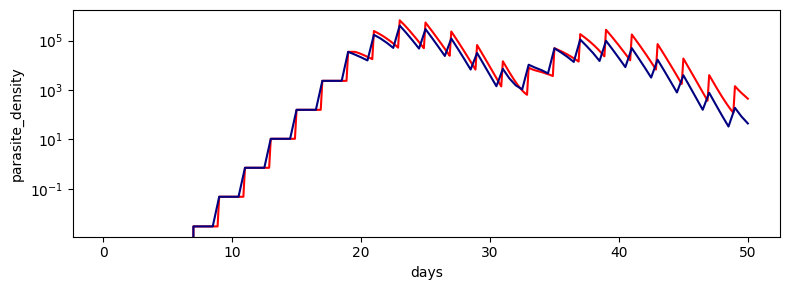

In [8]:
compare_timeseries(df_ts8, df_ts2)

**Note** that the random seeds for the two challenge trials are not synchronized, which means that the random draws of major/minor epitopes will not be in the same configuration.  As a consequence, the 2nd wave would be expected to vary substantially, not just because of different timestep approximations of exponential growth in antibody capacity above threshold, but also based on shared minor epitopes with first wave.

### Cytokine dynamics
Alternatively, we can look at the fever variable (linearly related to cytokine tracking variable) -- even though we've turned off their killing effects above...

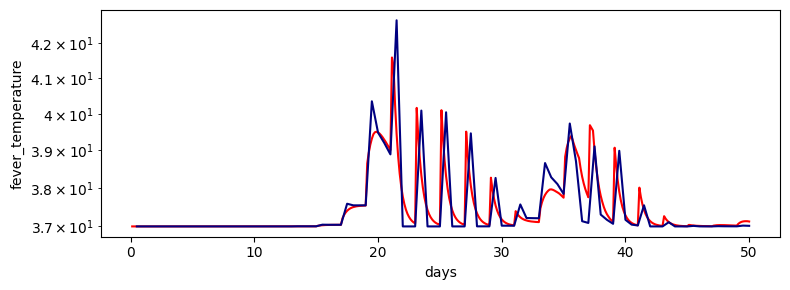

In [9]:
compare_timeseries(df_ts8, df_ts2, channel='fever_temperature')

In this comparison, we see the fast-timescale dynamics (12h decay constant) of the cytokine-decay process in action (see [corresponding code](https://github.com/edwenger/emodlib/blob/e115f3b26db89b8624e767c66f3b597b9f9c4c48/include/emodlib/malaria/SusceptibilityMalaria.cpp#L206) in Susceptibility class).

So we can see that it's probably not a good idea to naively use update steps larger than 12h if we care about cytokine-killing effects, fever dynamics, fever-triggered treatment, etc.  Below see behavior for 24h updates.

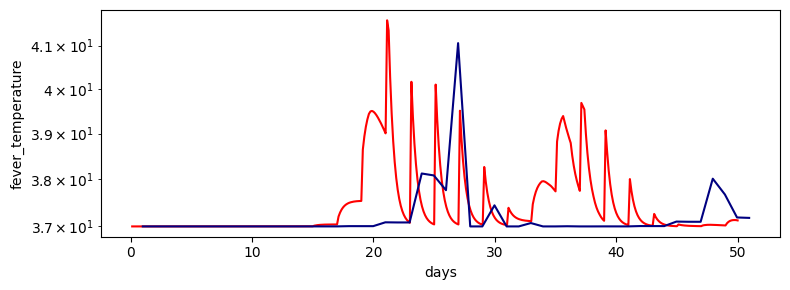

In [13]:
df_ts1 = run_challenge(duration=50, dt=0.999)
compare_timeseries(df_ts8, df_ts1, channel='fever_temperature')